In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)
from deepsphere.healpy_layers import HealpySmoothing

os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
import healpy as hp

from msfm.utils import files, redshift, clustering, scales, input_output
from msfm.fiducial_pipeline import FiducialPipeline

# setup

In [3]:
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v9/linear_bias.yaml"
conf = files.load_config(conf)
hp_datapath = "/global/u2/a/athomsen/multiprobe-simulation-forward-model/data/healpy_data"

dlss_conf = "/global/homes/a/athomsen/y3-deep-lss/configs/v8/combined/linear_bias/dlss_config.yaml"
dlss_conf = input_output.read_yaml(dlss_conf)
# dlss_conf = {
#     "scale_cuts" : {
#           "n_sigma_support": 3,
#           "arcmin": True,
#           "lensing": {
#             # 6 Mpc/h transverse comoving scale -> arcmin
#             "theta_fwhm": [22.1, 15.1, 11.2, 9.4]
#           },
#         "clustering" : {
#             # 16 Mpc/h transverse comoving scale -> arcmin
#             "theta_fwhm": [65.1, 44.5, 34.1, 28.5]
#         },
#     }
# }

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
l_min_global = 20
l_max_global = 1535
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file(conf)

# fiducial values
Aia = conf["analysis"]["fiducial"]["Aia"]
n_Aia = conf["analysis"]["fiducial"]["n_Aia"]

bg = conf["analysis"]["fiducial"]["bg"]
n_bg = conf["analysis"]["fiducial"]["n_bg"]

z0 = conf["analysis"]["modelling"]["z0"]

# metacal
metacal_bins = conf["survey"]["metacal"]["z_bins"]
n_z_metacal = len(metacal_bins)
tomo_z_metacal, tomo_nz_metacal = files.load_redshift_distributions("metacal", conf)
tomo_Aia = redshift.get_tomo_amplitudes(Aia, n_Aia, tomo_z_metacal, tomo_nz_metacal, z0)

# maglim
maglim_bins = conf["survey"]["metacal"]["z_bins"]
n_z_maglim = len(maglim_bins)
tomo_z_maglim, tomo_nz_maglim = files.load_redshift_distributions("maglim", conf)
tomo_n_gal_maglim = np.array(conf["survey"]["maglim"]["n_gal"]) * hp.nside2pixarea(n_side, degrees=True)
tomo_bg = redshift.get_tomo_amplitudes(bg, n_bg, tomo_z_maglim, tomo_nz_maglim, z0)

n_z = n_z_metacal + n_z_maglim

# scales
# theta_fwhms = [22.1, 15.1, 11.2, 9.4] + [65.1, 44.5, 34.1, 28.5]
theta_fwhms = dlss_conf["scale_cuts"]["lensing"]["theta_fwhm"] + dlss_conf["scale_cuts"]["clustering"]["theta_fwhm"]
l_maxs_naive = list(scales.angle_to_ell(np.array(theta_fwhms), arcmin=True).astype(int))

24-07-11 01:16:30     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


# load the full sky maps

In [4]:
%%time
# fidu_dir = "/global/cfs/cdirs/des/cosmogrid/v11desy3/fiducial/cosmo_fiducial"
fidu_dir = "/pscratch/sd/a/athomsen/v11desy3/fiducial/cosmo_fiducial"

n_examples = 10

wl = []
gc = []
for i in range(n_examples):
    with h5py.File(os.path.join(fidu_dir, f"perm_{i:04d}", "projected_probes_maps_v11dmb.h5"), "r") as f:
        kg = []
        ia = []
        for z_bin in metacal_bins:
            kg.append(hp.ud_grade(f[f"map/kg/{z_bin}"], n_side))
            ia.append(hp.ud_grade(f[f"map/ia/{z_bin}"], n_side))
        kg = np.stack(kg, axis=-1)
        ia = np.stack(ia, axis=-1)
        
        wl.append(kg + tomo_Aia * ia)

        dg = []
        for z_bin in maglim_bins:
            dg.append(hp.ud_grade(f[f"map/dg/{z_bin}"], n_side))
        dg = np.stack(dg, axis=-1)
        
        gc.append(clustering.galaxy_density_to_count(tomo_n_gal_maglim, (dg - np.mean(dg))/np.mean(dg), tomo_bg, nest=False))

wl = np.stack(wl, axis=0)
gc = np.stack(gc, axis=0)

fidu_maps = np.concatenate([wl, gc], axis=-1)

print(fidu_maps.shape)

(10, 3145728, 8)
CPU times: user 8min 55s, sys: 2min 17s, total: 11min 12s
Wall time: 11min 12s


# compute the $C_\ell$ and $\ell_\text{threshold}$

In [52]:
threshold = 0.1
# threshold = 0.01

raw_cls = np.zeros((n_examples, l_max_global+1, n_z))
for i, fidu_map in enumerate(fidu_maps):
    for j in range(fidu_map.shape[-1]):
        raw_cls[i,:,j] = hp.anafast(fidu_map[:,j], lmax=l_max_global, pol=False, datapath=hp_datapath, use_pixel_weights=True)
        
mean_cls = np.mean(raw_cls, axis=0)

l = np.arange(0, l_max_global+1)
smooth_cls = np.zeros_like(mean_cls)
l_maxs_thresh = []
cl_noise_levels = []
sigmas = []
for i in range(n_z):
    # smoothing
    low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(l, theta_fwhm=theta_fwhms[i], arcmin=True)**2
    smooth_cls[:,i] = low_pass_fac_cls * mean_cls[:,i]

    # determine the l_max when the Cls are suppressed by as much as the threshold
    try:
        l_max = l[low_pass_fac_cls < threshold][0]
    except IndexError:
        l_max = l_max_global
    l_maxs_thresh.append(l_max)
    
    # evaluate the full sky Cls at that l_max 
    cl_noise_level = smooth_cls[l_max,i]
    cl_noise_levels.append(cl_noise_level)
    
    # convert to a sigma of white Gaussian noise
    sigma = np.sqrt(cl_noise_level / hp.nside2pixarea(n_side))
    sigmas.append(sigma)
    
l_maxs_thresh = np.array(l_maxs_thresh)
cl_noise_levels = np.array(cl_noise_levels)
sigmas = np.array(sigmas)
    
print(f"l_maxs_thresh = {l_maxs_thresh}")
print(f"cl_noise_levels = {cl_noise_levels}")
print(f"sigmas = {sigmas}")

l_maxs_thresh = [ 556  814 1097 1307  189  276  360  431]
cl_noise_levels = [4.00421473e-12 7.22003725e-12 1.06895257e-11 1.16752668e-11
 1.71686315e-05 2.77273136e-06 1.59906076e-06 1.35280634e-06]
sigmas = [1.00118499e-03 1.34439030e-03 1.63581757e-03 1.70957855e-03
 2.07311547e+00 8.33123815e-01 6.32685870e-01 5.81933646e-01]


In [53]:
# threshold = 0.01
# l_maxs_thresh = [ 786 1150 1535 1535  267  390  509  610]
# cl_noise_levels = [2.14832910e-13 3.81379158e-13 6.96574599e-13 4.01907204e-12
#  1.08056365e-06 1.70188807e-07 8.92689078e-08 7.31340564e-08]
# sigmas = [2.31902835e-04 3.08982676e-04 4.17579788e-04 1.00304068e-03
#  5.20092784e-01 2.06405445e-01 1.49487804e-01 1.35305510e-01]

# plot the results

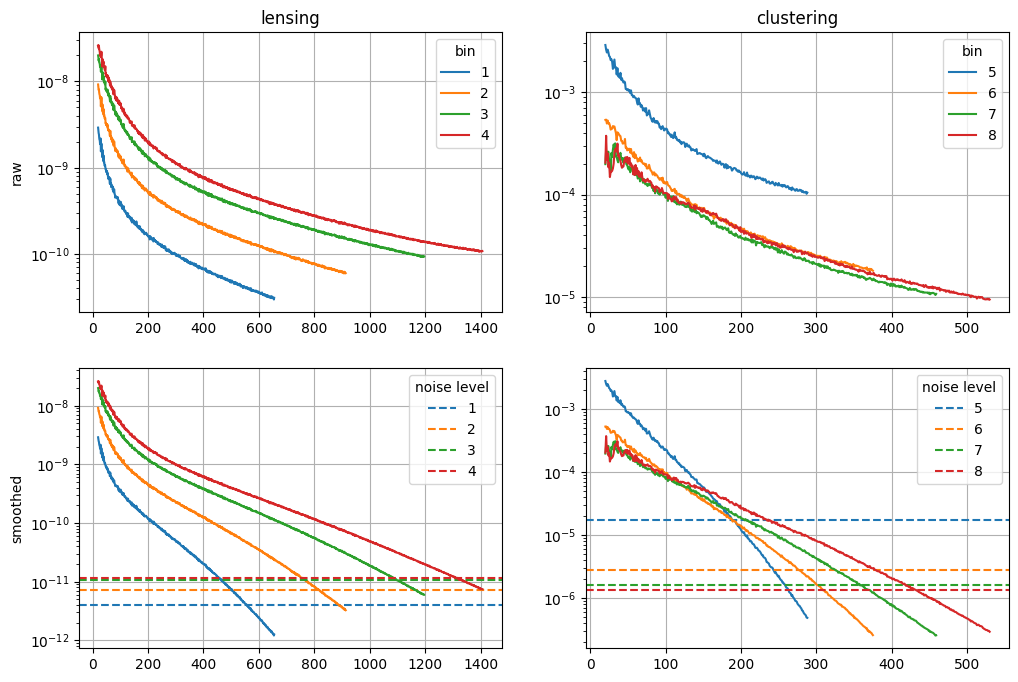

In [54]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=2, sharex=False, sharey=False)
# colors = sns.color_palette("hls", n_z)
colors = sns.color_palette("tab10", 4)

for i in range(n_z):
    j = 0 if i < n_z_metacal else 1
    l_max = l_maxs_thresh[i]
    l_max_plot = min(l_max + 100, l_max_global)
    l = np.arange(l_min_global, l_max_plot)

    ax[0,j].plot(l, mean_cls[l_min_global:l_max_plot,i], label=i+1, color=colors[i%4])
    ax[1,j].plot(l, smooth_cls[l_min_global:l_max_plot,i], color=colors[i%4])
    # ax[1,j].axvline(l_thresholds[i], linestyle="--", label=i+1, color=colors[i%4])
    ax[1,j].axhline(cl_noise_levels[i], linestyle="--", label=i+1, color=colors[i%4])

for i in range(2):
    for j in range(2):
        ax[i,j].grid(True)
        ax[i,j].set(xscale="linear", yscale="log")
    
ax[0,0].set(title="lensing", ylabel="raw")
ax[1,0].set(ylabel="smoothed")
ax[0,1].set(title="clustering")

ax[0,0].legend(loc="upper right", title="bin")
ax[0,1].legend(loc="upper right", title="bin")

ax[1,0].legend(loc="upper right", title="noise level")
ax[1,1].legend(loc="upper right", title="noise level")

fig.savefig(f"plots/cl_noise_level_1_threshold={threshold}.png", bbox_inches="tight", dpi=100)    

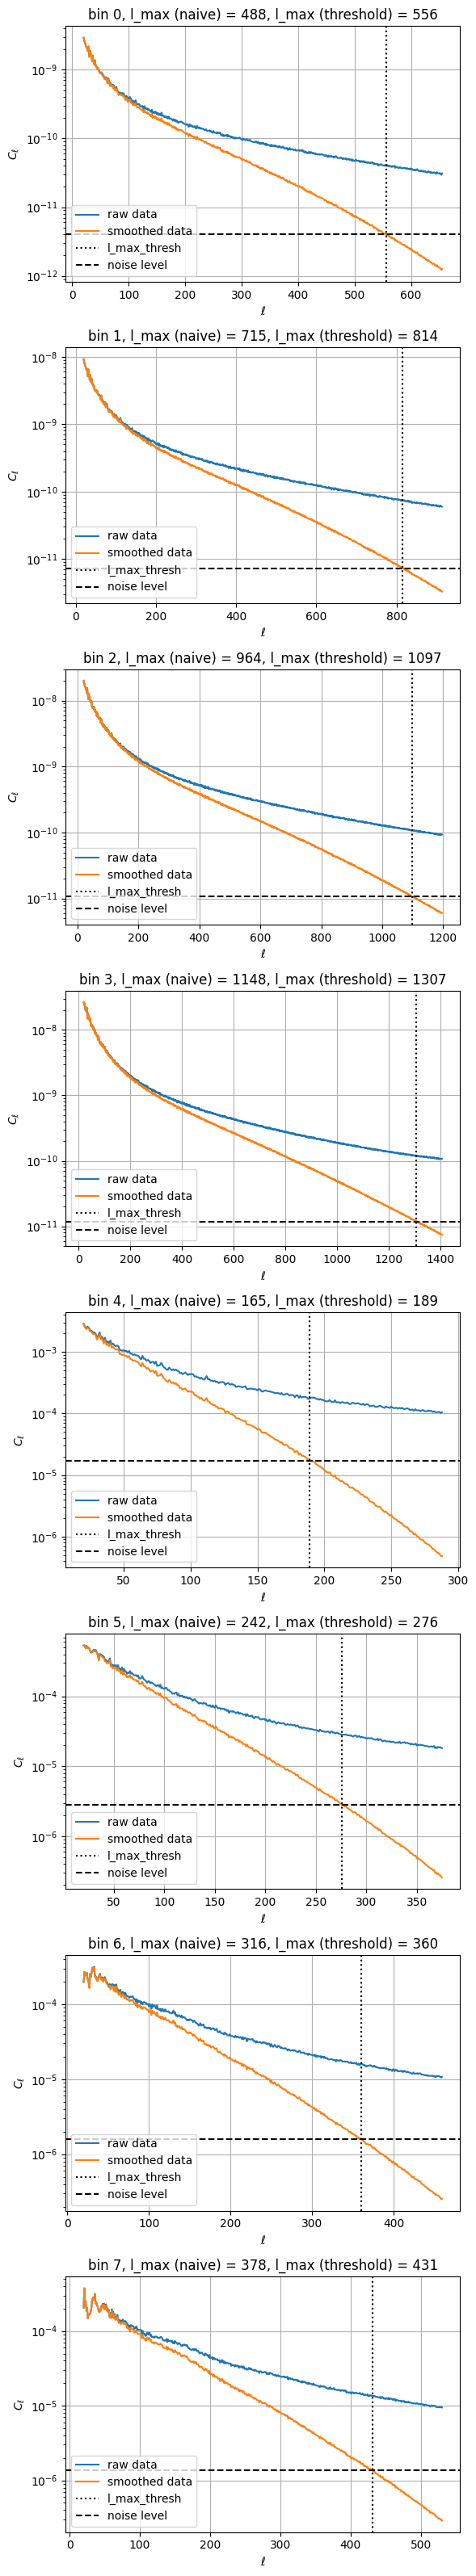

In [55]:
fig, ax = plt.subplots(figsize=(6, 4*n_z), nrows=n_z, sharex=False, sharey=False)

for i in range(n_z):
    l_max = l_maxs_thresh[i]
    l_max_plot = min(l_max + 100, l_max_global)
    l = np.arange(l_min_global, l_max_plot)
    
    ax[i].plot(l, mean_cls[l_min_global:l_max_plot,i], label="raw data")
    ax[i].plot(l, smooth_cls[l_min_global:l_max_plot,i], label="smoothed data")
    ax[i].axvline(l_maxs_thresh[i], color="k", linestyle=":", label="l_max_thresh")
    ax[i].axhline(cl_noise_levels[i], color="k", linestyle="--", label="noise level")
        
    ax[i].set(
        xscale="linear", 
        yscale="log", 
        title=f"bin {i}, l_max (naive) = {l_maxs_naive[i]}, l_max (threshold) = {l_max}", 
        xlabel=r"$\ell$", 
        ylabel=r"$C_\ell$", 
        # xlim=(, l_maxs_thresh[i] + 100),
        # ylim=(0.5 * mean_fidu_cls[32:l_max_noise,i].min(), 1.5 * mean_fidu_cls[32:l_max_noise,i].max()),
    )
    ax[i].grid(True)
    ax[i].legend(loc="lower left")
    
fig.tight_layout()
fig.savefig(f"plots/cl_noise_level_2_threshold={threshold}.png", bbox_inches="tight", dpi=100)    

### check the white noise

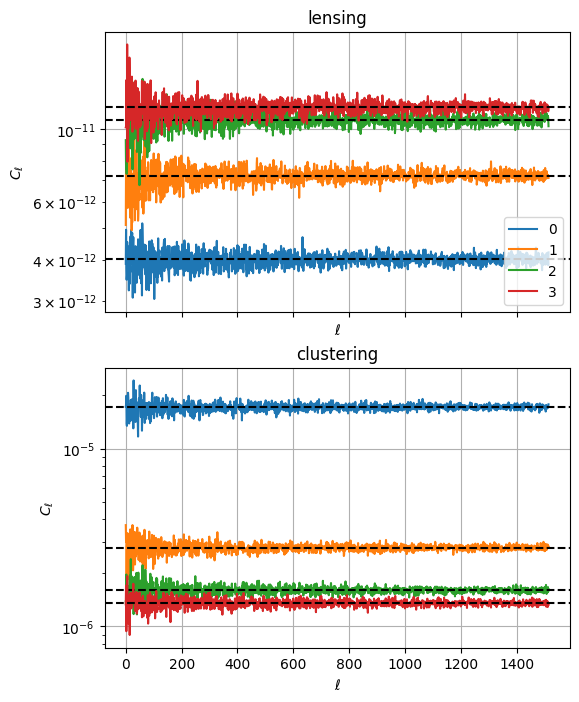

In [56]:
fig, ax = plt.subplots(figsize=(6,4*2), nrows=2, sharex=True)

rng = np.random.default_rng()
for i, sigma in enumerate(sigmas):
    noise_map = rng.normal(size=n_pix, loc=0, scale=sigma)
    noise_cls = hp.anafast(noise_map, lmax=l_max_global, pol=False, datapath=hp_datapath, use_pixel_weights=True)
    
    j = 0 if i<n_z_metacal else 1
    ax[j].plot(noise_cls[l_min_global:l_max_global], label=i)
    ax[j].axhline(cl_noise_levels[i], color="k", linestyle="--")

for i in range(2):
    ax[i].set(xscale="linear", yscale="log", xlabel=r"$\ell$", ylabel=r"$C_\ell$")
    ax[i].grid(True)
    
ax[0].set(title="lensing")
ax[1].set(title="clustering")
ax[0].legend(loc="best")

### take the normalization of the maps into account

In [65]:
# the galaxy clustering maps don't get a normalization factor
map_normalization = np.array(conf["analysis"]["normalization"]["lensing"] + 4 * [1])
# normalized_sigmas = np.sqrt(np.array(cl_noise_levels)/map_normalization**2 / hp.nside2pixarea(n_side))
normalized_sigmas = sigmas/map_normalization

print(f"{threshold*100} percent")
print(f"normalized_sigmas = {normalized_sigmas}")

10.0 percent
normalized_sigmas = [0.11641686 0.09813068 0.0940125  0.07465408 2.07311547 0.83312381
 0.63268587 0.58193365]


# smoothing layer

In [58]:
mask_dict = files.get_tomo_dv_masks(conf)
    
mask = tf.concat([mask_dict["metacal"], mask_dict["maglim"]], axis=1)
mask = mask.numpy()

smoothing_kwargs = {
    "nside": n_side,
    "indices": data_vec_pix,
    "nest": True,
    # "mask": mask,
    "fwhm": theta_fwhms,
    "arcmin": True,
    "n_sigma_support": dlss_conf["scale_cuts"]["n_sigma_support"],
    # "white_noise_sigma": normalized_sigmas,
    "white_noise_sigma": sigmas,
    "data_path": ".",
}
noisy_smoothing_layer = tf.function(HealpySmoothing(**smoothing_kwargs))

smoothing_kwargs["white_noise_sigma"] = None
smoothing_layer = tf.function(HealpySmoothing(**smoothing_kwargs))

24-07-11 01:51:42     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
Using the per channel smoothing repetitions [ 6  3  2  1 48 23 14 10]
Using the per channel smoothing scales sigma = [ 9.78  6.91  5.65  3.99 27.66 19.14 14.94 12.62] arcmin, fwhm = [23.03 16.28 13.29  9.4  65.13 45.08 35.17 29.73] arcmin
Successfully loaded sparse kernel indices and values from .
Successfully created the sparse kernel tensor
Adding white noise with sigma [1.00118499e-03 1.34439030e-03 1.63581757e-03 1.70957855e-03
 2.07311547e+00 8.33123815e-01 6.32685870e-01 5.81933646e-01] to the smoothed map
Warning, you're adding white noise to the maps but haven't provided a mask! The noise will extend to the padding
Using the per channel smoothing repetitions [ 6  3  2  1 48 23 14 10]
Using the per channel smoothing scales sigma = [ 9.78  6.91  5.65  3.99 27.66 19.14 14.94 12.62] arcmin, fwhm = [23.03 16.28 13.29  9.4  65.13 45.08 35.

### load maps from .tfrecords

In [59]:
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v9/linear_bias/tfrecords/ficudial_backup/DESy3_fiducial_dmb_0000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v9/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"

fidu_pipe = FiducialPipeline(
    conf=conf,
    params=[],
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False,
    # apply_norm=True,
    shape_noise_scale=1.0,
    poisson_noise_scale=1.0,
)

fidu_dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    noise_indices=10,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=2,
    is_eval=True,
)

for dv, index in fidu_dset.take(1):
    dv_smooth = smoothing_layer(dv)
    dv_noisy = noisy_smoothing_layer(dv)

print(dv.shape)
print(dv_smooth.shape)
print(dv_noisy.shape)

24-07-11 01:51:45     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-07-11 01:51:45     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-07-11 01:51:45 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-07-11 01:51:45 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-07-11 01:51:45 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-07-11 01:51:45 fiducial_pip INF   Including noise_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
24-07-11 01:51:45 fiducial_pip INF   Interleaving with n_readers = 1 
24-07-11 01:51:45 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-07-11 01:51:45 fiducial_pip WAR   Tracing _augmentations 
24-07

### compare the $C_\ell$

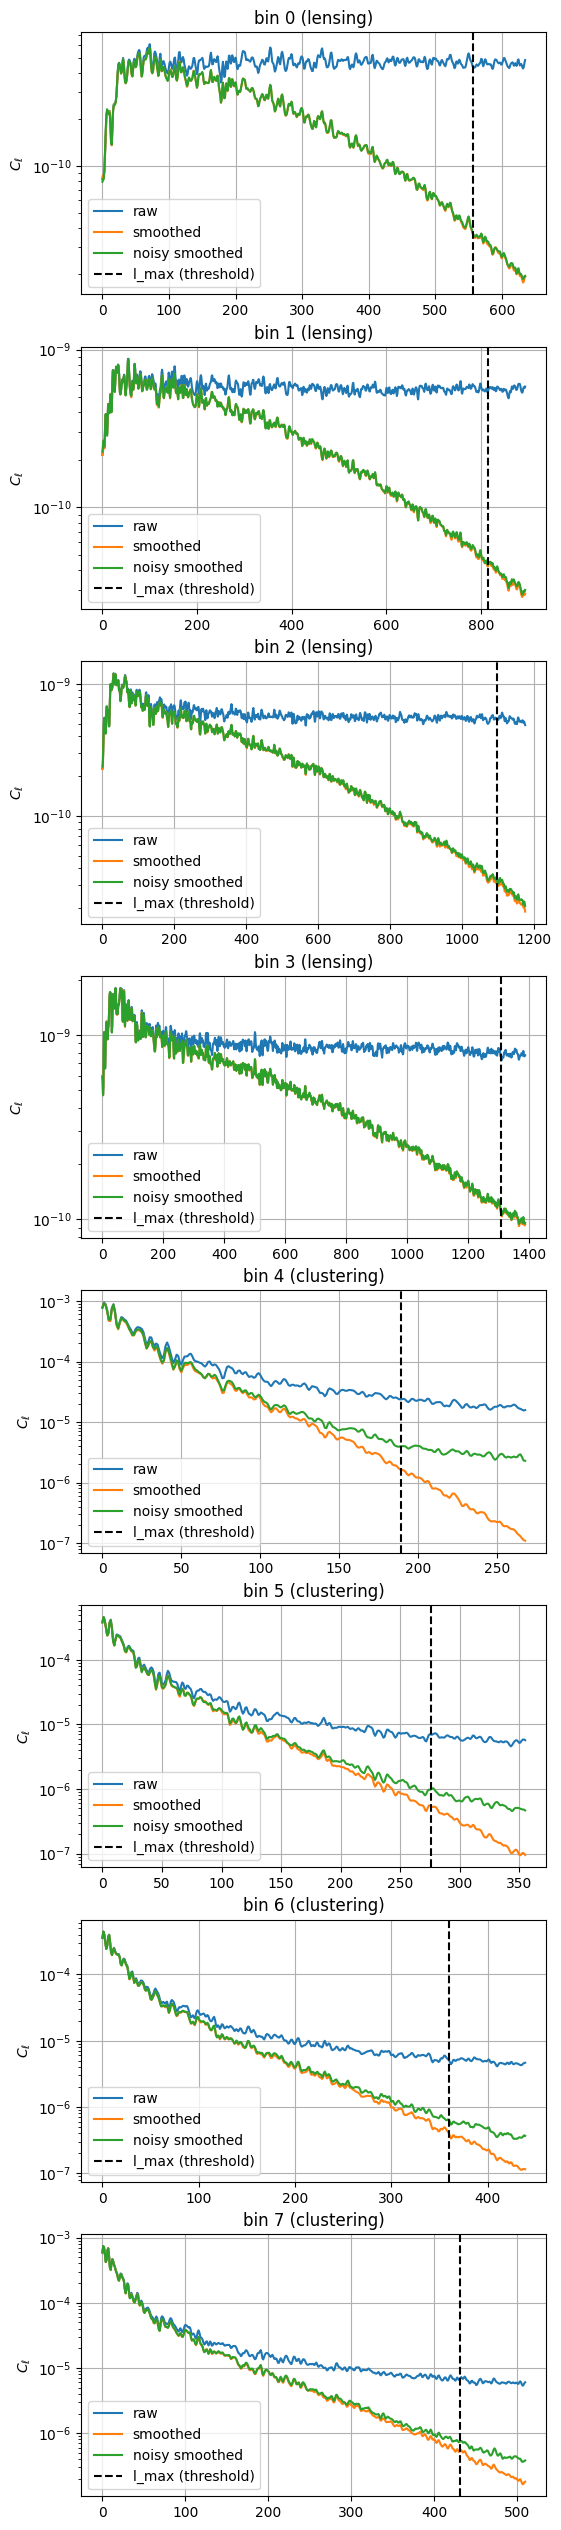

In [60]:
fig, ax = plt.subplots(figsize=(6, 4*n_z), nrows=n_z, sharex=False, sharey=False)

for i in range(n_z):
    l_max = l_maxs_thresh[i]
    l_max_plot = min(l_max + 100, l_max_global)    

    raw_map = np.zeros(n_pix)
    raw_map[data_vec_pix] = dv[0,:,i]
    raw_map = hp.reorder(raw_map, n2r=True)
    raw_cls = hp.anafast(raw_map)

    smoothed_map = np.zeros(n_pix)
    smoothed_map[data_vec_pix] = dv_smooth[0,:,i]
    smoothed_map = hp.reorder(smoothed_map, n2r=True)
    smoothed_cls = hp.anafast(smoothed_map)

    noisy_map = np.zeros(n_pix)
    noisy_map[data_vec_pix] = dv_noisy[0,:,i]
    noisy_map = hp.reorder(noisy_map, n2r=True)
    noisy_cls = hp.anafast(noisy_map)

    ax[i].plot(raw_cls[l_min_global:l_max_plot], label="raw")
    ax[i].plot(smoothed_cls[l_min_global:l_max_plot], label="smoothed")
    ax[i].plot(noisy_cls[l_min_global:l_max_plot], label="noisy smoothed")

    # # smoothed on cl level
    # low_pass_fac_cls = scales.gaussian_low_pass_factor_alm(np.arange(3*n_side), theta_fwhm=theta_fwhms[i])**2
    # noisy_cls_direct = low_pass_fac_cls * raw_cls
    # noisy_cls_direct_2 = scales.cls_to_smoothed_cls(raw_cls, theta_fwhm=theta_fwhms[i])
    # ax[i].plot(noisy_cls_direct, label=r"noisy ($C_\ell$ level, $a_{\ell m}$ fac)")
    # ax[i].plot(noisy_cls_direct_2, label=r"smoothed ($C_\ell$ level, direct)")

    ax[i].axvline(l_maxs_thresh[i], color="k", linestyle="--", label="l_max (threshold)")
    probe = "lensing" if i < n_z_metacal else "clustering"
    ax[i].set(ylabel=r"$C_\ell$", xscale="linear", yscale="log", title=f"bin {i} ({probe})" )
    ax[i].grid(True)
    ax[i].legend(loc="lower left")
    
fig.savefig(f"plots/result_cl_comparison_threshold={threshold}.png", bbox_inches="tight", dpi=100)    

### compare the maps

In [61]:
i_fid = 0

# in degrees
x_deg = 10
y_deg = x_deg
# in pixels
x_pix = 600
y_pix = x_pix
# in arcminute / pixel
reso = x_deg / x_pix * 60

rot = (90, -30, 0)

gnoms = np.zeros((3, x_pix, y_pix, n_z))

# noiseless
for i_z in range(n_z):
    hp_map = np.zeros(n_pix)
    hp_map[data_vec_pix] = dv[i_fid,:,i_z]
    gnom = hp.gnomview(hp_map, nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True)
    gnoms[0, ..., i_z] = gnom

# smoothed
for i_z in range(n_z):
    hp_map = np.zeros(n_pix)
    hp_map[data_vec_pix] = dv_smooth[i_fid,:,i_z]
    gnom = hp.gnomview(hp_map, nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True)
    gnoms[1, ..., i_z] = gnom
    
# noisy
for i_z in range(n_z):
    hp_map = np.zeros(n_pix)
    hp_map[data_vec_pix] = dv_noisy[i_fid,:,i_z]
    gnom = hp.gnomview(hp_map, nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True)
    gnoms[2, ..., i_z] = gnom

gnoms = np.ma.masked_where(gnoms==0, gnoms)

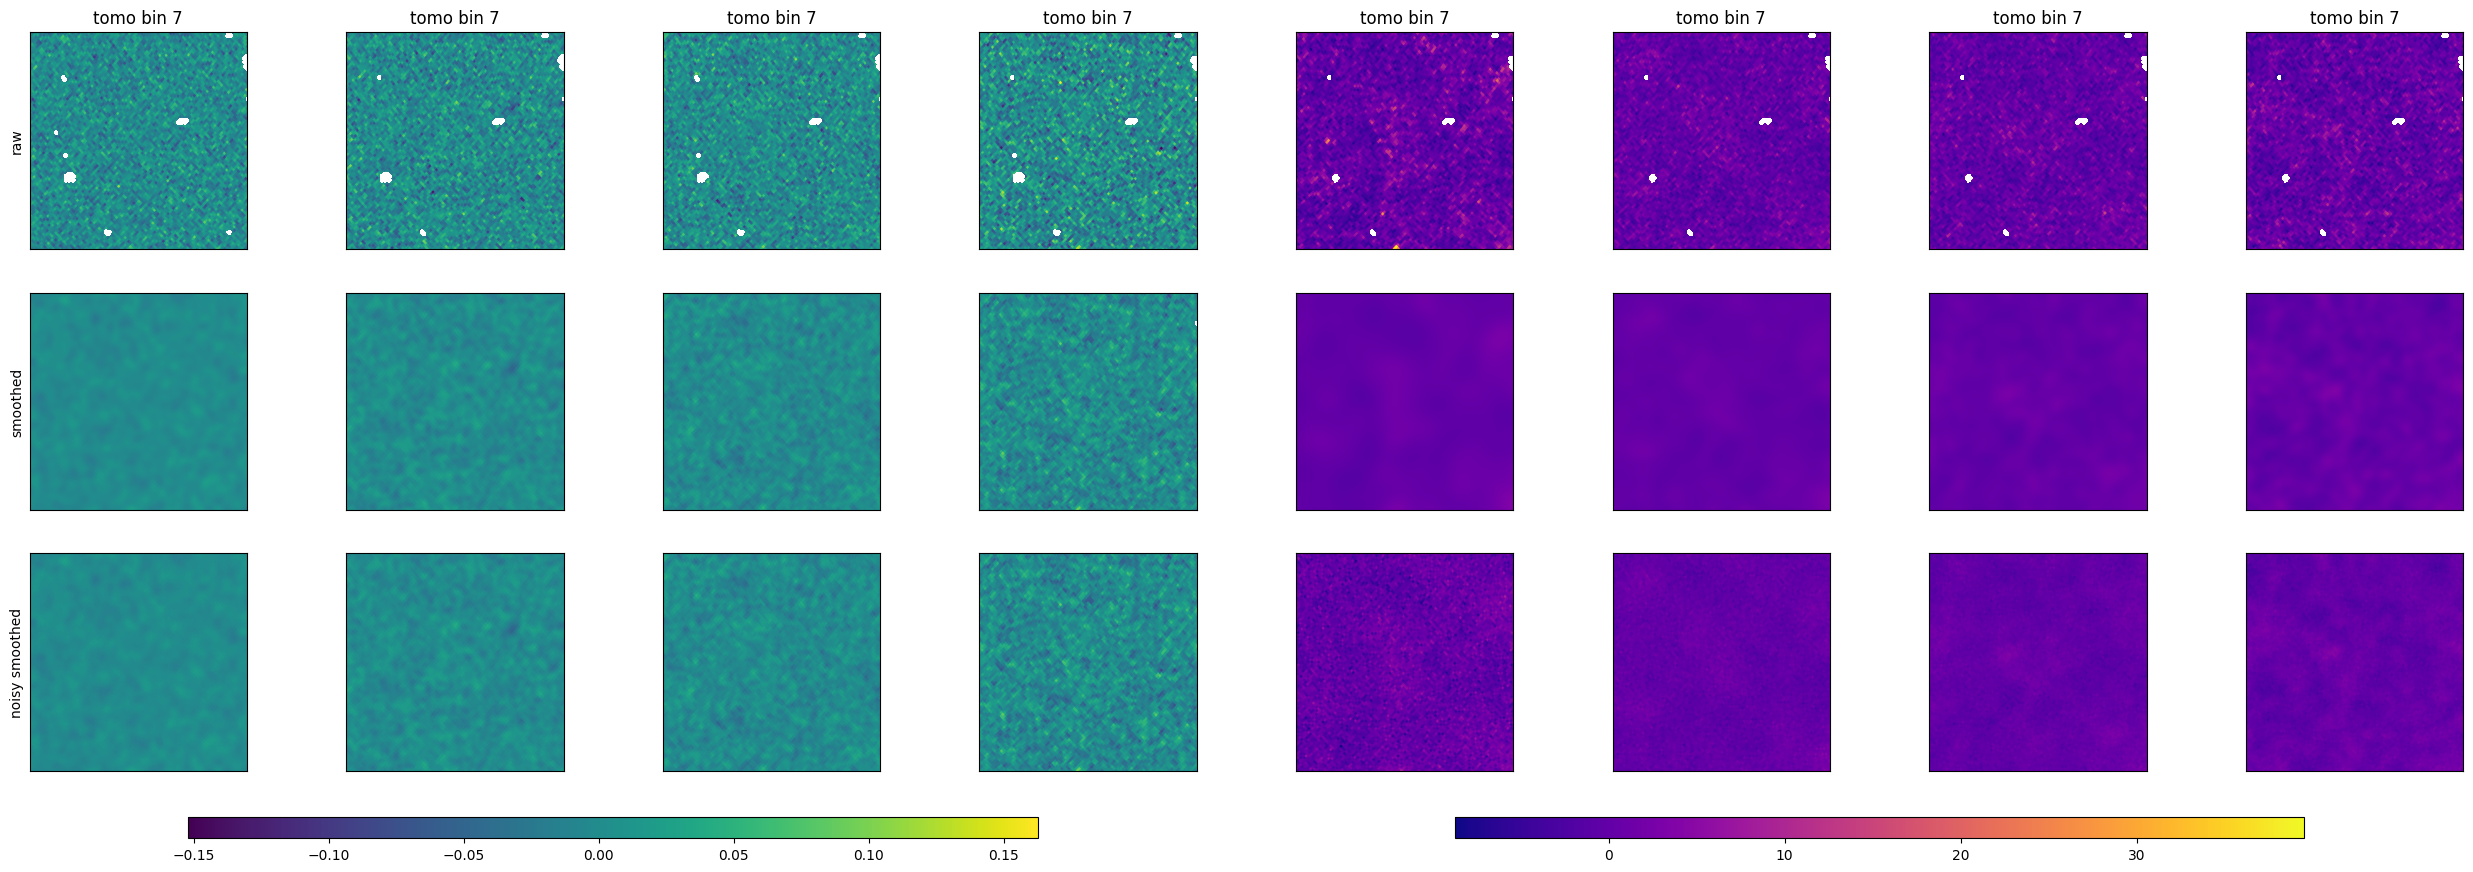

In [62]:
fig, ax = plt.subplots(figsize=(4*n_z, 4*3), nrows=3, ncols=n_z)

wl_min = np.array(gnoms[...,:n_z_metacal]).min()
wl_max = np.array(gnoms[...,:n_z_metacal]).max()

gc_min = np.array(gnoms[...,n_z_metacal:]).min()
gc_max = np.array(gnoms[...,n_z_metacal:]).max()

row_labels = ["raw", "smoothed", "noisy smoothed"]
for i in range(3):
    for j in range(n_z):
        # lensing
        if j < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"
            probe = "lensing"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            cmap = "plasma"
            probe = "clustering"

        gnom = gnoms[i,...,j]
        im = ax[i, j].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_aspect("equal")

        if j == 0:
            ax[i,j].set(ylabel=row_labels[i])

        if i == 0:
            ax[i,j].set(title=f"tomo bin {i_z}")

        if i == 2:
            if j == 0:
                fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
            if j == 4:
                fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
fig.savefig(f"plots/result_map_comparison_threshold={threshold}.png", bbox_inches="tight", dpi=100)    